In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib_venn import venn3, venn2
from matplotlib.patches import Patch
from hydra import initialize, compose
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import SVG
from tqdm import tqdm
from minedatabase.pickaxe import Pickaxe
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

def make_venn2(left: set, right: set, left_name: str, right_name: str, left_color: tuple = (0,0,1,1), right_color: tuple = (1,0,0,1), do_save: bool = False):
    Ab = len(left - right)
    aB = len(right - left)
    AB = len(left & right)
    plt.figure()
    v = venn2(subsets = (Ab, aB, AB), set_labels = (left_name, right_name))
    v.get_patch_by_id('10').set_color(left_color)
    v.get_patch_by_id('01').set_color(right_color)

    plt.tight_layout()
    if do_save:
        plt.savefig(Path(cfg.figures) / f"{left_name.replace(' ','_')}_vs_{right_name.replace(' ','_')}_venn2.svg", format="svg")
    plt.show()

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

In [2]:
starters_name = "250728_benchmark_starters"
expansion_name = f"2_steps_{starters_name}"
a_plus_b = True
rule_sets = [
    'mechinformed',
    'mechinferred_dt_956',
    'mechinferred_dt_224',
    'mechinferred_dt_112',
    'mechinferred_dt_039',
    'mechinferred_dt_019',
    'rc_plus_1',
]

known_reactions = {}

for rule_set in rule_sets:
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[rule_set] = rxns
    del mapped_rxns

ds = 10
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*reaction_metrics.parquet"):
    rule_set = str(p.stem).split("_rules_")[1]
    if rule_set not in rule_sets:
        continue
   
    df = pd.read_parquet(p)
    df['rule_set'] = rule_set
    dfes.append(df)

rxn_df = pd.concat(dfes, ignore_index=True)
del dfes, df

print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["rule_set"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
rxn_df = rxn_df.explode("rules")
rxn_df['rules'] = rxn_df['rules'].apply(lambda x : x.split('_')[0])
rxn_df['rules'] = rxn_df.apply(lambda row : f"{row['rule_set']}_rule_{row['rules']}", axis=1)
print(len(rxn_df))
rxn_df.head()

/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_956_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_224_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_112_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_039_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_019_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
730280
919977


,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,rule_set,known
0,R35e196dd0cbbbb3e8e9d0d6de5072659d71e89fd167a2...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.900000,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2cdec316ece01e7bc421cee6847fef5284fb3e25,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
1,R4444c69647517c3fde72a45e9ed7c8b693fa62ac9d0e0...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,1,0.927105,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2f348cb02270404e553309450ac1b208a96282b7,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_209,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_2730,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False
6,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,0,0.710047,O=C(O)CCC(=O)O.CCCCCCCCCCCCCCCCOCC(O)COP(=O)(O...,4cd0fad17eb2966d09b5636f489e8ca1e32ca941,mechinferred_dt_956_rule_155,2_steps_250728_benchmark_starters_rules_mechin...,mechinferred_dt_956,False


In [3]:
known_reactions.keys()

dict_keys(['mechinformed', 'mechinferred_dt_956', 'mechinferred_dt_224', 'mechinferred_dt_112', 'mechinferred_dt_039', 'mechinferred_dt_019', 'rc_plus_1'])

In [4]:
template_sizes = pd.read_csv(
    Path(cfg.processed_data) / "template_size_stats.csv"
)
template_sizes.head(10)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_956_rules,3,3.0,4.0,5.501385,7.0,15
1,mechinferred_dt_224_rules,3,5.0,9.0,9.293601,13.0,30
2,mechinferred_dt_112_rules,3,7.0,11.0,12.484241,16.0,70
3,mechinferred_dt_039_rules,3,9.0,14.5,17.270657,20.0,133
4,mechinferred_dt_019_rules,3,12.0,24.0,26.119228,35.0,172
5,rc_plus_0_rules,3,4.0,6.0,6.695736,9.0,15
6,rc_plus_1_rules,3,6.0,8.0,8.889249,12.0,31
7,rc_plus_2_rules,3,10.0,12.0,13.415592,17.0,35
8,rc_plus_3_rules,3,12.0,16.0,17.150463,22.0,44
9,rc_plus_4_rules,3,14.0,21.0,20.757402,27.0,51


In [5]:
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.956",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.224",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.112",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.039",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.019",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': "Pathway-level clustering",
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': "RDChiral",
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("darkorange"),
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("blue"),
}

exp_names = list(exp_labels.keys())

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

In [6]:
rids = {}
for exp_name, short_name in exp_labels.items():
    rids[short_name] = set(rxn_df.loc[rxn_df["expansion"] == exp_name, "id"].values)

rids.pop("RC + 0")

set()

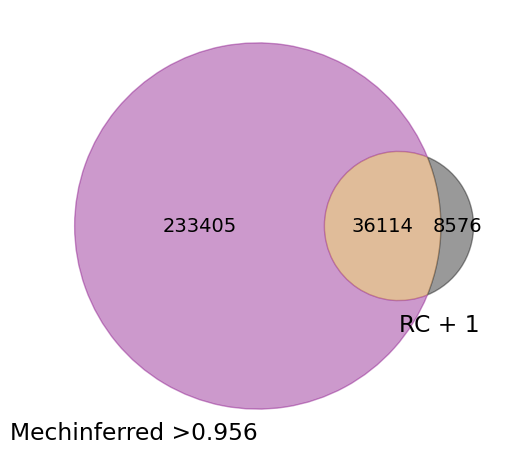

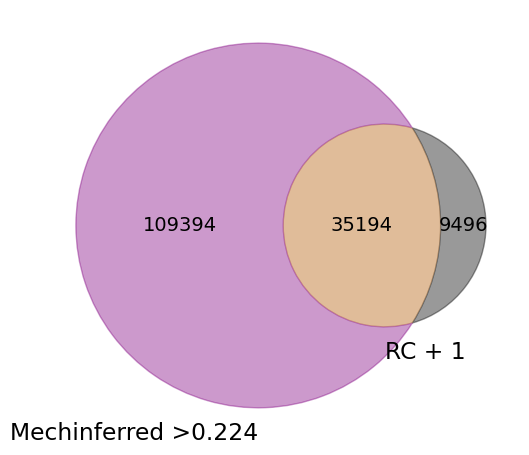

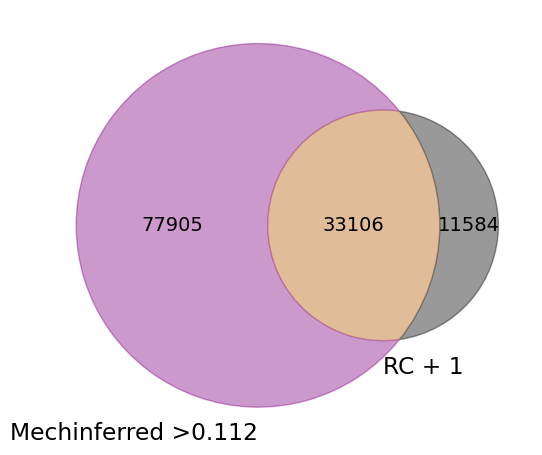

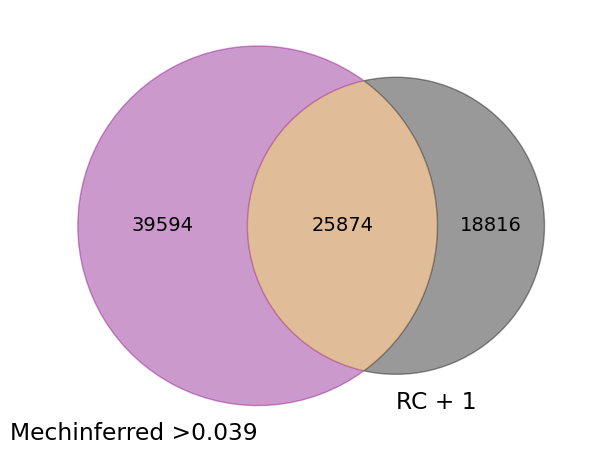

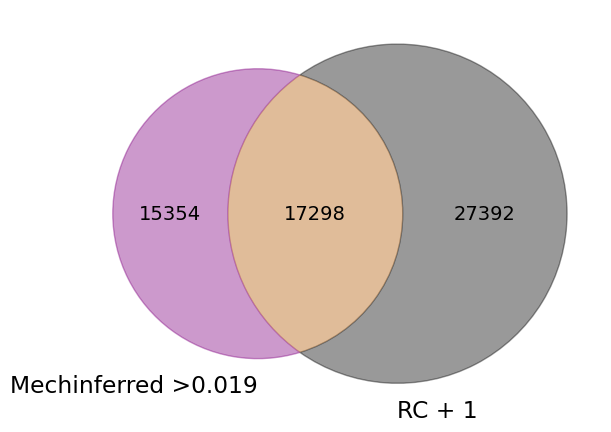

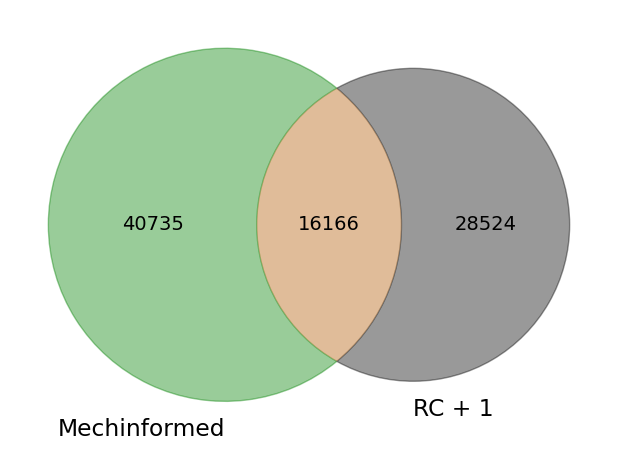

In [7]:
make_venn2(rids["Mechinferred >0.956"], rids["RC + 1"], "Mechinferred >0.956", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.224"], rids["RC + 1"], "Mechinferred >0.224", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.85), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.112"], rids["RC + 1"], "Mechinferred >0.112", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.6), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.039"], rids["RC + 1"], "Mechinferred >0.039", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.45), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinferred >0.019"], rids["RC + 1"], "Mechinferred >0.019", "RC + 1", left_color=matplotlib.colors.to_rgba("purple", alpha=0.3), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)
make_venn2(rids["Mechinformed"], rids["RC + 1"], "Mechinformed", "RC + 1", left_color=matplotlib.colors.to_rgba("green", alpha=1.0), right_color=matplotlib.colors.to_rgba("black", alpha=0.85), do_save=True)

In [29]:

pk = Pickaxe()
pk.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading /home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk pickled data.


FileNotFoundError: [Errno 2] No such file or directory: '/home/stef/cgr/data/interim/2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk'

In [ ]:
starters = set()

for cid, cpd in pk.compounds.items():
    if cpd["Type"] == "Starting Compound":
        starters.add(cpd["SMILES"])

In [ ]:
mechinfo_only_df = rxn_df.loc[
    (rxn_df["expansion"] == "2_steps_ccm_aa_rules_mechinformed_rules_w_coreactants_aplusb_True.pk") & (rxn_df["id"].isin(mechinfo_only))
]

mechinfo_only_df = mechinfo_only_df.sort_values(by=["dxgb_label", "max_rxn_sim"], ascending=False)
print(len(mechinfo_only_df))
mechinfo_only_df_first_gen = mechinfo_only_df.loc[mechinfo_only_df["smarts"].apply(lambda x: any([elt in starters for elt in x.split('>>')[0].split('.')]))].reset_index()
print(len(mechinfo_only_df_first_gen))
mechinfo_only_df_first_gen.head()

In [ ]:
def show_rxn_info(idx):
    row = mechinfo_only_df_first_gen.iloc[idx]
    print(row["id"])
    print("Predicted:")
    display(SVG(draw_reaction(row["smarts"])))
    print("-" * 50)
    print("Nearest analogue:")
    display(SVG(draw_reaction(row["nearest_analogue"])))

srt_idx = mechinfo_only_df_first_gen.index
interact(show_rxn_info, idx=widgets.Dropdown(options=srt_idx, value=srt_idx[0]))

In [ ]:
rc1exp = Pickaxe()
rc1exp.load_pickled_pickaxe(Path(cfg.interim_data) / "2_steps_ccm_aa_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk")

In [ ]:
rc1exp.reactions['Rc1d16b2f24a2c9ad05cf3eed4ffe2d1ac938d51a93a35ed469e573297dea6da9']